In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import meq

In [3]:
import torch
import pyro
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist
import arviz as az

In [4]:
def single_prev_inc(params, eir):
    p = meq.default_parameters()
    p.kb, p.ub, p.b0, p.b1, p.IB0 = params
    p.EIR = eir
    solution = meq.solve(p)
    return (
        np.array(solution.pos_M)[3:10].sum() / np.array(solution.prop)[3:10].sum(),
        np.array(solution.pos_M)[10:30].sum() / np.array(solution.prop)[10:30].sum(),
        np.array(solution.pos_M)[30:].sum() / np.array(solution.prop)[30:].sum(),
        np.array(solution.inc)[:5].sum() / np.array(solution.prop)[:5].sum(),
        np.array(solution.inc)[5:15].sum() / np.array(solution.prop)[5:15].sum(),
        np.array(solution.inc)[15:].sum() / np.array(solution.prop)[15:].sum()
    )

In [5]:
#experiments = 10
kb = np.random.gamma(4., 1.)
ub = np.random.lognormal(1., 1.)
b0 = np.random.beta(7., 1.)
b1 = np.random.beta(1., 10.)
IB0 = np.random.gamma(5., .1)

In [6]:
population = 100_000
EIR = 21.

In [7]:
observations = [round(v * population) for v in single_prev_inc([kb, ub, b0, b1, IB0], EIR)]

In [8]:
observations

[2095, 2397, 1986, 7, 11, 13]

In [9]:
def model():
    kb = pyro.sample('kb', dist.Gamma(4., 1.))
    ub = pyro.sample('ub', dist.LogNormal(1., 1.))
    b0 = pyro.sample('b0', dist.Beta(7., 1.))
    b1 = pyro.sample('b1', dist.Beta(1., 10.))
    IB0 = pyro.sample('IB0', dist.Gamma(5., .1))
    pred_prev = single_prev_inc([kb, ub, b0, b1, IB0], EIR)
    pyro.sample(
        'obs_prev',
        dist.Independent(
            dist.Binomial(torch.as_tensor(population), torch.as_tensor(pred_prev)),
            1
        )
    )

In [10]:
conditioned = pyro.condition(
    model,
    data={
        'obs_prev': torch.as_tensor(observations)
    }
)

In [11]:
n_samples = 100
n_warmup = 100
n_chains = 10

nuts_kernel = NUTS(conditioned, jit_compile=False)
mcmc = MCMC(
    nuts_kernel,
    num_samples=n_samples,
    warmup_steps=n_warmup,
    num_chains=n_chains,
)
mcmc.run()
mcmc.summary(prob=0.7)

Warmup [1]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [9]:   0%|          | 0/200 [00:00, ?it/s]

Warmup [10]:   0%|          | 0/200 [00:00, ?it/s]


                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0      2.65      3.39      0.50      0.00      4.44      5.07     25.09
        b0      0.44      0.30      0.36      0.09      0.73      5.04     32.79
        b1      0.18      0.22      0.18      0.00      0.20      5.04     26.76
        kb      3.60      2.82      2.84      0.11      4.97      5.20     11.42
        ub      1.76      1.80      1.09      0.20      2.53      5.57      5.40

Number of divergences: 15


In [14]:
IB0, b0, b1, kb, ub

(0.37043495954933103,
 0.8881579866530886,
 0.18151629046567413,
 1.0881082767945844,
 2.0039264648722073)

In [15]:
from pyro.infer import Predictive

In [16]:
prior = Predictive(model, num_samples=600)()

In [17]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(conditioned, posterior_samples)()

In [18]:
pyro_data = az.from_pyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


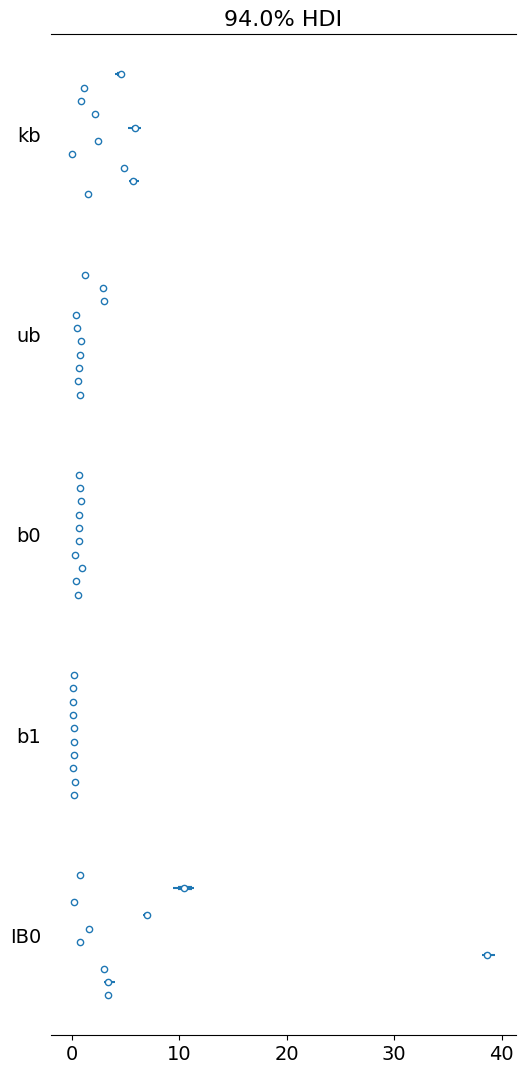

In [19]:
axs = az.plot_forest(pyro_data, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

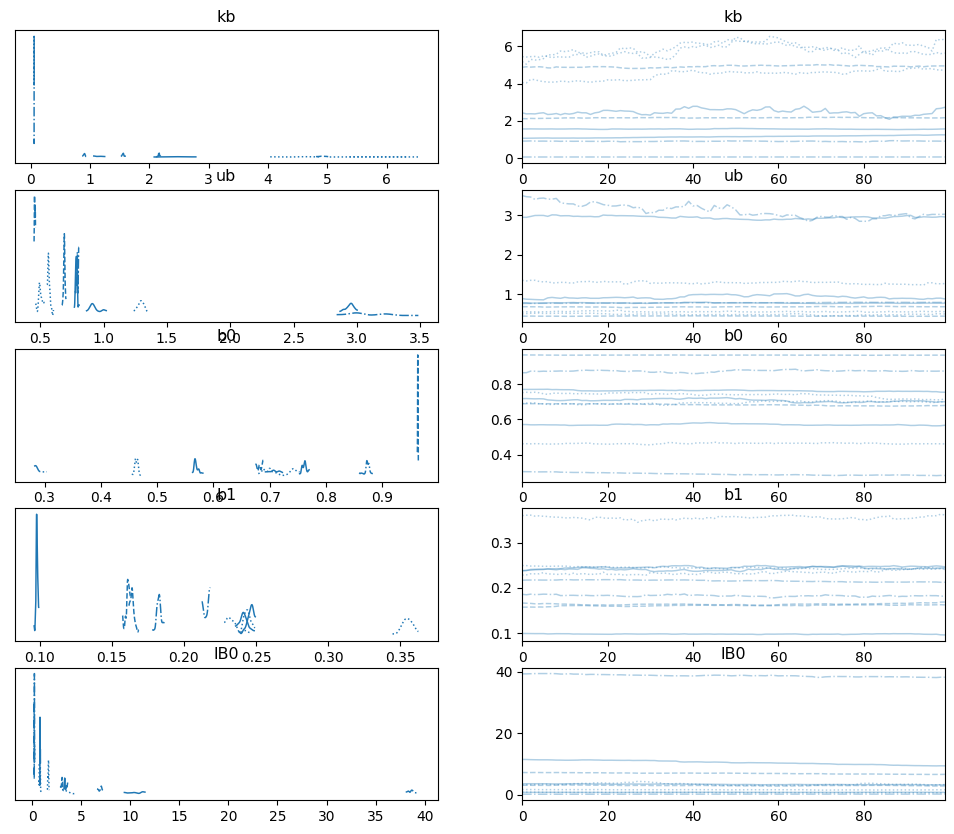

In [20]:
axs = az.plot_trace(pyro_data, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

In [24]:
posterior_predictive

{'obs_prev': tensor([[37693, 26957, 16420,   232,   188,    79],
         [37693, 26957, 16420,   232,   188,    79],
         [37693, 26957, 16420,   232,   188,    79],
         ...,
         [37693, 26957, 16420,   232,   188,    79],
         [37693, 26957, 16420,   232,   188,    79],
         [37693, 26957, 16420,   232,   188,    79]])}

In [25]:
observations

[37693, 26957, 16420, 232, 188, 79]

In [26]:
posterior_samples

{'IB0': tensor([ 3.6073,  3.6096,  3.6159,  3.6095,  3.6154,  3.6059,  3.5964,  3.5519,
          3.5588,  3.5818,  3.5957,  3.5937,  3.5963,  3.6005,  3.5838,  3.5870,
          3.5322,  3.5438,  3.5223,  3.5220,  3.5325,  3.4807,  3.4521,  3.4411,
          3.4867,  3.5207,  3.5322,  3.5207,  3.5052,  3.4915,  3.4800,  3.5079,
          3.5236,  3.5456,  3.5740,  3.5044,  3.4990,  3.4951,  3.4974,  3.4656,
          3.4572,  3.4569,  3.4507,  3.4590,  3.4387,  3.4268,  3.4062,  3.4088,
          3.3810,  3.3420,  3.3414,  3.3419,  3.3772,  3.3569,  3.3524,  3.2926,
          3.2921,  3.2882,  3.3100,  3.3204,  3.3296,  3.3132,  3.3149,  3.3937,
          3.3855,  3.3858,  3.3381,  3.3320,  3.3321,  3.3314,  3.3291,  3.3367,
          3.3214,  3.3324,  3.3530,  3.3558,  3.3240,  3.3215,  3.3193,  3.3199,
          3.2917,  3.3086,  3.3160,  3.2963,  3.2971,  3.3085,  3.3175,  3.3280,
          3.3378,  3.3320,  3.3167,  3.3089,  3.3096,  3.3162,  3.2715,  3.2524,
          3.2670,  3.